<a href="https://colab.research.google.com/github/shreyas1209/Stock-Market-Prediction/blob/main/Stock_Market_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader,Dataset 
from torchvision import transforms
from torchvision import datasets
from math import *
from sklearn.metrics import mean_squared_error
%matplotlib inline


Loading Data for Google,Amazon and Apple Stocks

In [3]:
google_data = pd.read_csv('/content/drive/MyDrive/Stock_market_prediction/GOOGL_2006-01-01_to_2018-01-01.csv')
amazon_data = pd.read_csv('/content/drive/MyDrive/Stock_market_prediction/AMZN_2006-01-01_to_2018-01-01.csv')
apple_data = pd.read_csv('/content/drive/MyDrive/Stock_market_prediction/AAPL_2006-01-01_to_2018-01-01.csv')

In [4]:
print(google_data.shape)
google_data.head(5)

(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [5]:
print(amazon_data.shape)
amazon_data.head(5)

(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [6]:
print(apple_data.shape)
apple_data.head(5)

(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Plotting Data for stocks

In [7]:
google_close = google_data[['Close']]
amazon_close = amazon_data[['Close']]
apple_close  = apple_data[['Close']]

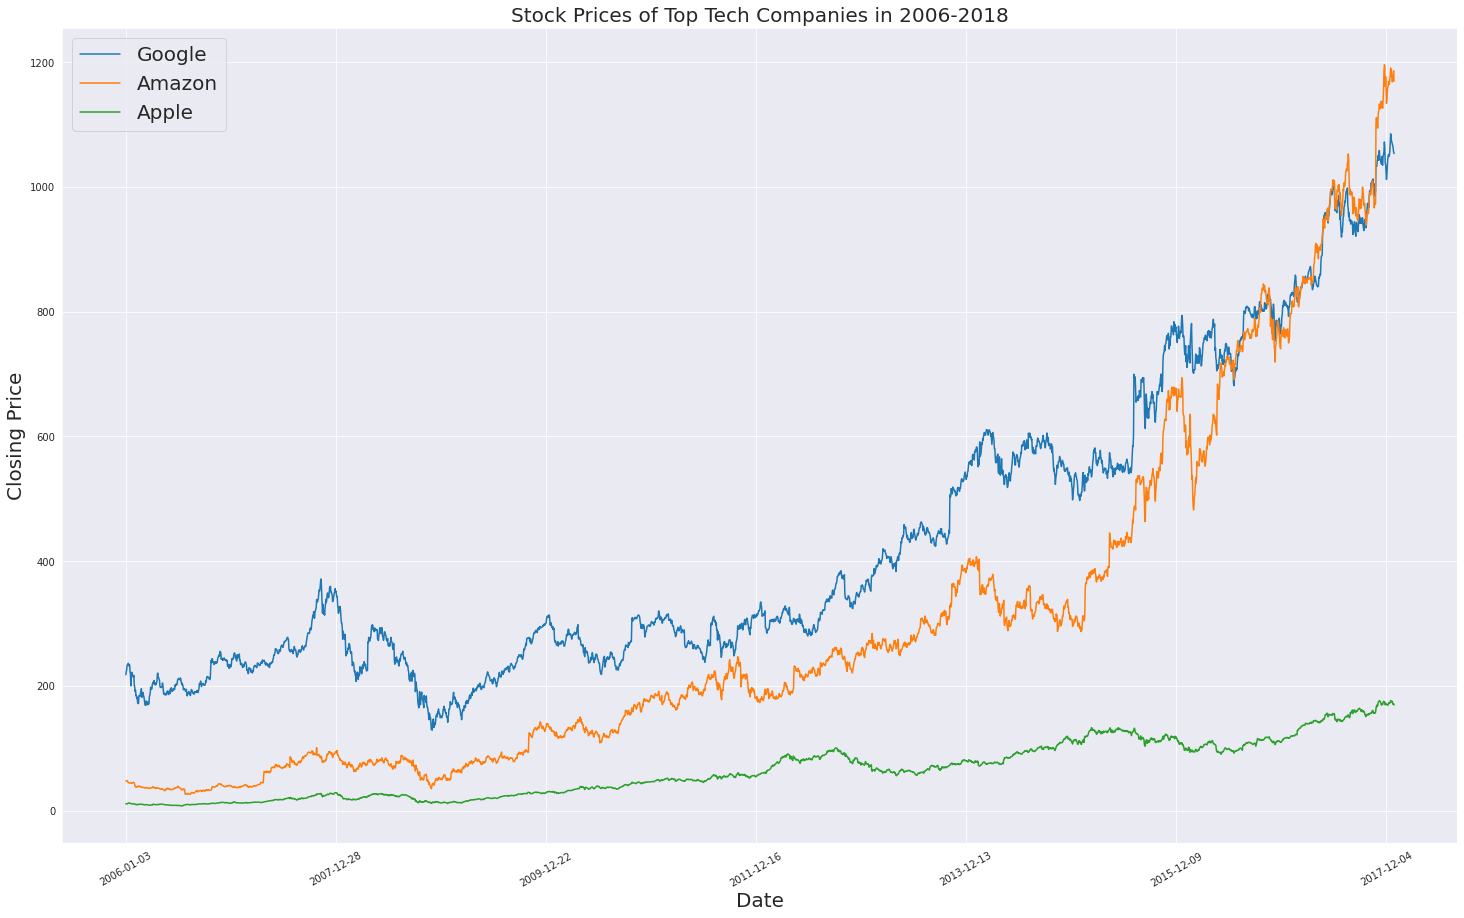

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
plt.plot(google_close,label='Google')
plt.plot(amazon_close,label='Amazon')
plt.plot(apple_close,label ='Apple')
plt.xticks(range(0,google_data.shape[0],500),google_data['Date'].loc[::500],rotation=30)
plt.legend(prop={'size': 20})
plt.title("Stock Prices of Top Tech Companies in 2006-2018",fontdict={'fontsize':20})
plt.xlabel('Date',fontdict={'fontsize':20})
plt.ylabel('Closing Price',fontdict={'fontsize':20})
plt.show()


Normalizing the data

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

google_close = scaler.fit_transform(google_close.values.reshape(-1,1))
amazon_close = scaler.fit_transform(amazon_close.values.reshape(-1,1))
apple_close = scaler.fit_transform(apple_close.values.reshape(-1,1))


Splitting the train and test data

In [10]:
#use of prior time steps to predict the next time step with window_width
def train_test_split(stock,window_width,train_split_pct):
  stock_data = []
  init_data_length = len(stock)

  for i in range(init_data_length-window_width):
    data_window = stock[i:i+window_width]
    stock_data.append(data_window)
  stock_data = np.array(stock_data)
  data_size = len(stock_data)
  train_size = int(np.round(data_size*train_split_pct))
  X_train = stock_data[:train_size,:-1,:]
  y_train = stock_data[:train_size,-1,:]
    
  X_test = stock_data[train_size:,:-1]
  y_test = stock_data[train_size:,-1,:]
    
  return (X_train, y_train, X_test, y_test)
   

Splitting data for all three companies

In [11]:
google_X_train,google_y_train,google_X_test, google_y_test = train_test_split(stock = google_close,
                                                                              window_width = 25,
                                                                              train_split_pct = 0.75,
                                                                              )
google_X_train = torch.from_numpy(google_X_train.astype(np.float32))
google_y_train = torch.from_numpy(google_y_train.astype(np.float32))
google_X_test = torch.from_numpy(google_X_test.astype(np.float32))
google_y_test = torch.from_numpy(google_y_test.astype(np.float32))
print('X_train.shape = ',google_X_train.shape)
print('y_train.shape = ',google_y_train.shape)
print('X_test.shape = ',google_X_test.shape)
print('y_test.shape = ',google_y_test.shape)

X_train.shape =  torch.Size([2246, 24, 1])
y_train.shape =  torch.Size([2246, 1])
X_test.shape =  torch.Size([748, 24, 1])
y_test.shape =  torch.Size([748, 1])


In [12]:
amazon_X_train,amazon_y_train,amazon_X_test, amazon_y_test = train_test_split(stock = amazon_close,
                                                                              window_width = 25,
                                                                              train_split_pct = 0.75,
                                                                              )
amazon_X_train = torch.from_numpy(amazon_X_train.astype(np.float32))
amazon_y_train = torch.from_numpy(amazon_y_train.astype(np.float32))
amazon_X_test = torch.from_numpy(amazon_X_test.astype(np.float32))
amazon_y_test = torch.from_numpy(amazon_y_test.astype(np.float32))
print('X_train.shape = ',amazon_X_train.shape)
print('y_train.shape = ',amazon_y_train.shape)
print('X_test.shape = ',amazon_X_test.shape)
print('y_test.shape = ',amazon_y_test.shape)

X_train.shape =  torch.Size([2246, 24, 1])
y_train.shape =  torch.Size([2246, 1])
X_test.shape =  torch.Size([748, 24, 1])
y_test.shape =  torch.Size([748, 1])


In [13]:
apple_X_train,apple_y_train,apple_X_test, apple_y_test = train_test_split(stock = apple_close,
                                                                              window_width = 20,
                                                                              train_split_pct = 0.8,
                                                                              )
apple_X_train = torch.from_numpy(apple_X_train.astype(np.float32))
apple_y_train = torch.from_numpy(apple_y_train.astype(np.float32))
apple_X_test = torch.from_numpy(apple_X_test.astype(np.float32))
apple_y_test = torch.from_numpy(apple_y_test.astype(np.float32))
print('X_train.shape = ',apple_X_train.shape)
print('y_train.shape = ',apple_y_train.shape)
print('X_test.shape = ',apple_X_test.shape)
print('y_test.shape = ',apple_y_test.shape)

X_train.shape =  torch.Size([2399, 19, 1])
y_train.shape =  torch.Size([2399, 1])
X_test.shape =  torch.Size([600, 19, 1])
y_test.shape =  torch.Size([600, 1])


In [14]:
import sys
sys.path.append('/content/drive/MyDrive/Stock_market_prediction/notebooks')
from stock_market_models import *
from stock_market_train import *

In [15]:
input_size = 1
hidden_size = 32
output_size = 1



In [16]:
model = LSTM(input_size = input_size,hidden_size = hidden_size,output_size = output_size)

In [17]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100

Training the data for Google

In [18]:
google_train_pred = train(google_X_train,google_y_train,model,loss_func,optimizer,epochs=100)

Epoch  1 Loss:  0.5968368053436279 Time:  0.4242611460000001
Epoch  2 Loss:  0.40465930104255676 Time:  0.3421136690000002
Epoch  3 Loss:  0.21456624567508698 Time:  0.35440073699999974
Epoch  4 Loss:  0.0585319958627224 Time:  0.3515673389999998
Epoch  5 Loss:  0.3209926187992096 Time:  0.37354582599999997
Epoch  6 Loss:  0.12356828153133392 Time:  0.35524895399999945
Epoch  7 Loss:  0.05438747629523277 Time:  0.3378249140000005
Epoch  8 Loss:  0.07059794664382935 Time:  0.3469877309999996
Epoch  9 Loss:  0.0953684151172638 Time:  0.35662747100000036
Epoch  10 Loss:  0.10799241811037064 Time:  0.34405141300000075
Epoch  11 Loss:  0.10810535401105881 Time:  0.34699103799999964
Epoch  12 Loss:  0.09959784895181656 Time:  0.33844468699999997
Epoch  13 Loss:  0.0866682380437851 Time:  0.3485877359999998
Epoch  14 Loss:  0.07305969297885895 Time:  0.3541696650000006
Epoch  15 Loss:  0.0618261881172657 Time:  0.34255122999999976
Epoch  16 Loss:  0.05503014102578163 Time:  0.3503936319999994

In [19]:
amazon_train_pred=train(amazon_X_train,amazon_y_train,model,loss_func,optimizer,epochs=100)

Epoch  1 Loss:  0.0005308081163093448 Time:  0.34013120899999905
Epoch  2 Loss:  0.00037178845377638936 Time:  0.3460651030000008
Epoch  3 Loss:  0.00043031954555772245 Time:  0.35032346799999914
Epoch  4 Loss:  0.0004714782699011266 Time:  0.342744377999999
Epoch  5 Loss:  0.00034876950667239726 Time:  0.3505938520000029
Epoch  6 Loss:  0.00039935039239935577 Time:  0.356768203999998
Epoch  7 Loss:  0.0004101877857465297 Time:  0.3515408609999966
Epoch  8 Loss:  0.0003163384390063584 Time:  0.34648051599999974
Epoch  9 Loss:  0.00035630035563372076 Time:  0.3519241839999978
Epoch  10 Loss:  0.00034750124905258417 Time:  0.3503394869999994
Epoch  11 Loss:  0.0002804440155159682 Time:  0.3483841070000011
Epoch  12 Loss:  0.0003185145906172693 Time:  0.3431726099999963
Epoch  13 Loss:  0.0002942366118077189 Time:  0.3499211190000011
Epoch  14 Loss:  0.0002534413943067193 Time:  0.3559174819999953
Epoch  15 Loss:  0.00028495880542322993 Time:  0.3565825820000015
Epoch  16 Loss:  0.0002495

In [20]:

apple_train_pred=train(apple_X_train,apple_y_train,model,loss_func,optimizer,epochs=100)

Epoch  1 Loss:  0.010365874506533146 Time:  0.29709711700000696
Epoch  2 Loss:  0.008667330257594585 Time:  0.3071944769999959
Epoch  3 Loss:  0.006049773655831814 Time:  0.2987027350000062
Epoch  4 Loss:  0.003676170716062188 Time:  0.30690925199999697
Epoch  5 Loss:  0.003189460840076208 Time:  0.3103040879999952
Epoch  6 Loss:  0.004974616691470146 Time:  0.30676663200000576
Epoch  7 Loss:  0.004626008216291666 Time:  0.2977587999999969
Epoch  8 Loss:  0.0018046923214569688 Time:  0.30150159499999063
Epoch  9 Loss:  0.0008999195415526628 Time:  0.3145461529999949
Epoch  10 Loss:  0.0019889494869858027 Time:  0.2999672140000058
Epoch  11 Loss:  0.0030410189647227526 Time:  0.3029398859999901
Epoch  12 Loss:  0.002979728626087308 Time:  0.314103805000002
Epoch  13 Loss:  0.0020674944389611483 Time:  0.31199817199998847
Epoch  14 Loss:  0.0013989679282531142 Time:  0.3045064709999963
Epoch  15 Loss:  0.0015997656155377626 Time:  0.2898549039999949
Epoch  16 Loss:  0.0018712374148890376

In [22]:

google_train_predict = pd.DataFrame(scaler.inverse_transform(google_train_pred.detach().numpy()))
amazon_train_predict = pd.DataFrame(scaler.inverse_transform(amazon_train_pred.detach().numpy()))
apple_train_predict = pd.DataFrame(scaler.inverse_transform(apple_train_pred.detach().numpy()))



In [25]:
google_close_train = pd.DataFrame(scaler.inverse_transform(google_y_train.detach().numpy()))
amazon_close_train = pd.DataFrame(scaler.inverse_transform(amazon_y_train.detach().numpy()))
apple_close_train = pd.DataFrame(scaler.inverse_transform(apple_y_train.detach().numpy()))

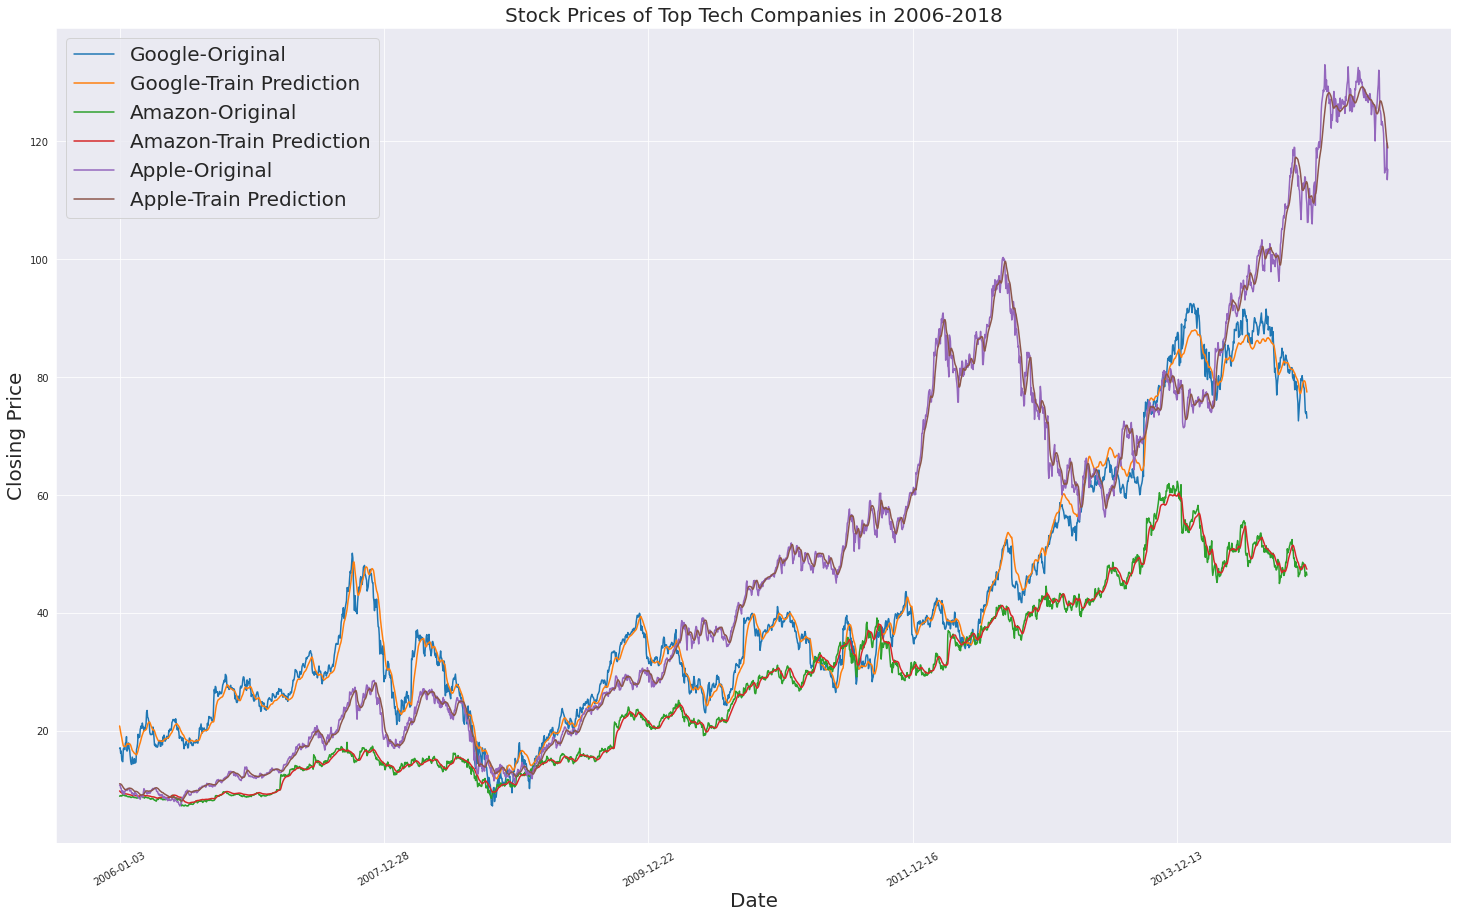

In [32]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
plt.plot(google_close_train,label='Google-Original')
plt.plot(google_train_predict,label='Google-Train Prediction')

plt.plot(amazon_close_train,label='Amazon-Original')
plt.plot(amazon_train_predict,label='Amazon-Train Prediction')


plt.plot(apple_close_train,label ='Apple-Original')
plt.plot(apple_train_predict,label ='Apple-Train Prediction')

plt.xticks(range(0,google_close_train.shape[0],500),google_data['Date'].loc[::500],rotation=30)
plt.legend(prop={'size': 20})
plt.title("Stock Prices of Top Tech Companies in 2006-2018",fontdict={'fontsize':20})
plt.xlabel('Date',fontdict={'fontsize':20})
plt.ylabel('Closing Price',fontdict={'fontsize':20})
plt.show()

Predicting on the test data

In [29]:
google_test_pred = model(google_X_test)
amazon_test_pred = model(amazon_X_test)
apple_test_pred = model(apple_X_test)


In [30]:
google_test_predict = pd.DataFrame(scaler.inverse_transform(google_test_pred.detach().numpy()))
amazon_test_predict = pd.DataFrame(scaler.inverse_transform(amazon_test_pred.detach().numpy()))
apple_test_predict = pd.DataFrame(scaler.inverse_transform(apple_test_pred.detach().numpy()))


In [33]:
google_close_test = pd.DataFrame(scaler.inverse_transform(google_y_test.detach().numpy()))
amazon_close_test = pd.DataFrame(scaler.inverse_transform(amazon_y_test.detach().numpy()))
apple_close_test = pd.DataFrame(scaler.inverse_transform(apple_y_test.detach().numpy()))


In [50]:
google_train_score = sqrt(mean_squared_error(google_train_predict[:], google_close_train[:]))
print('Google Train Score:{} RMS error'.format(google_train_score))
google_test_score = sqrt(mean_squared_error(google_test_predict[:], google_close_test[:]))
print('Google Test Score: {} RMS error'.format(google_test_score))

Google Train Score:2.022086852588286 RMS error
Google Test Score: 9.172983755651446 RMS error


In [52]:
amazon_train_score = sqrt(mean_squared_error(amazon_train_predict[:], amazon_close_train[:]))
print('Amazon Train Score:{} RMS error'.format(amazon_train_score))
amazon_test_score = sqrt(mean_squared_error(amazon_test_predict[:], amazon_close_test[:]))
print('Amazon Test Score: {} RMS error'.format(amazon_test_score))

Amazon Train Score:0.929457948698949 RMS error
Amazon Test Score: 7.652741792305374 RMS error


In [51]:
apple_train_score = sqrt(mean_squared_error(apple_train_predict[:], apple_close_train[:]))
print('Apple Train Score:{} RMS error'.format(apple_train_score))
apple_test_score = sqrt(mean_squared_error(apple_test_predict[:], apple_close_test[:]))
print('Apple Test Score: {} RMS error'.format(apple_test_score))

Apple Train Score:1.6449545997221608 RMS error
Apple Test Score: 10.543743386348511 RMS error


In [61]:
google_original = np.append(google_close_train, google_close_test, axis=0)
amazon_original = np.append(amazon_close_train, amazon_close_test, axis=0)
apple_original = np.append(apple_close_train, apple_close_test, axis=0)


In [62]:
google_predicted = np.append(google_train_predict,google_test_predict,axis=0)
amazon_predicted = np.append(amazon_train_predict,amazon_test_predict,axis=0)
apple_predicted = np.append(amazon_train_predict,amazon_test_predict,axis=0)

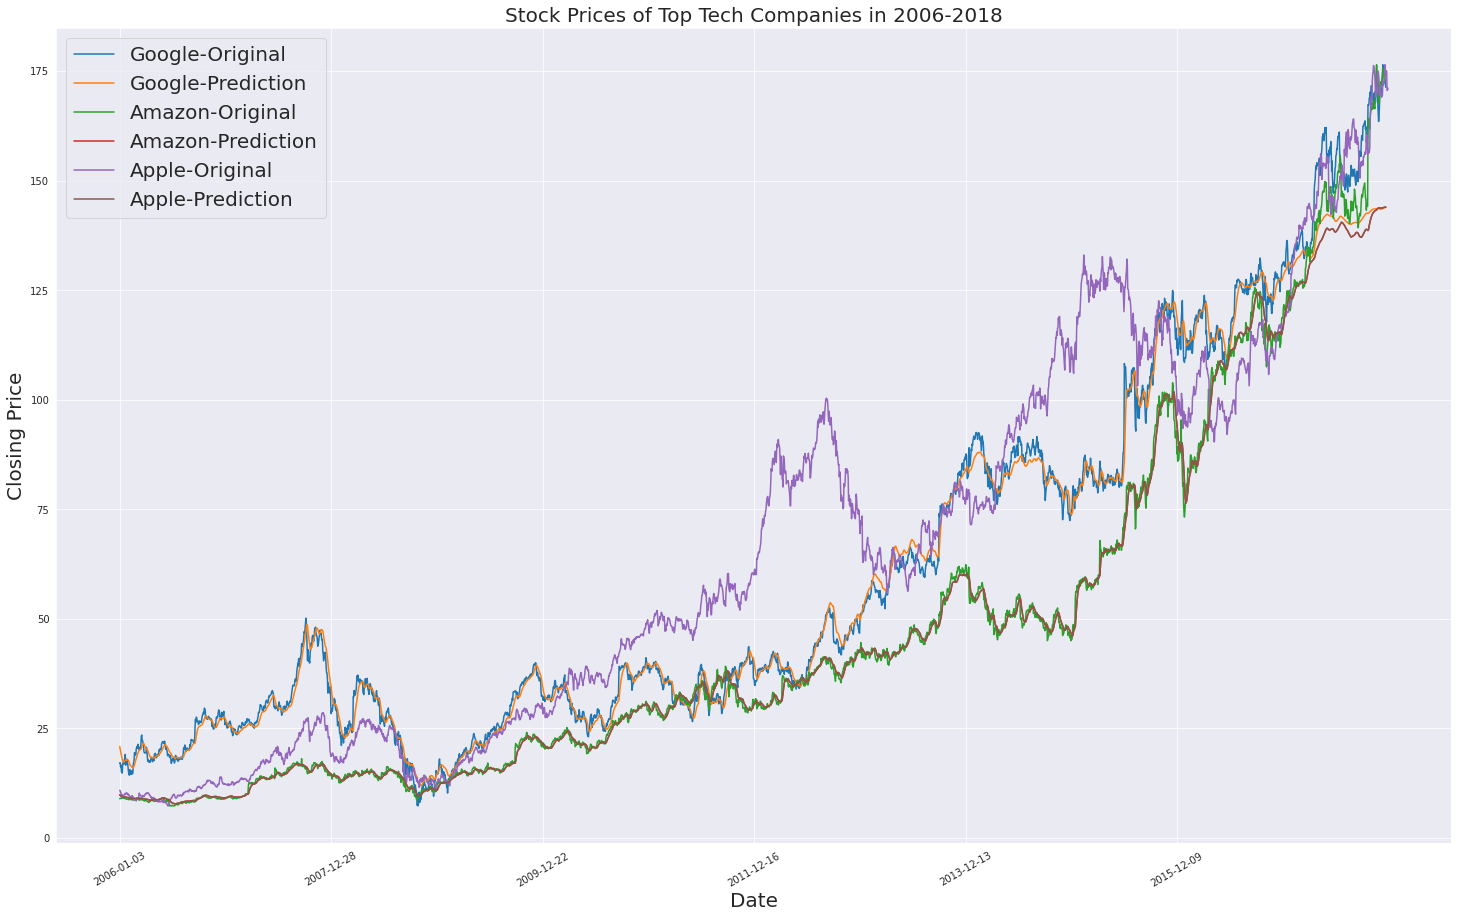

In [63]:
sns.set_style("darkgrid")
plt.figure(figsize = (25,15))
plt.plot(google_original,label='Google-Original')
plt.plot(google_predicted,label='Google-Prediction')

plt.plot(amazon_original,label='Amazon-Original')
plt.plot(amazon_predicted,label='Amazon-Prediction')


plt.plot(apple_original,label ='Apple-Original')
plt.plot(apple_predicted,label ='Apple-Prediction')

plt.xticks(range(0,google_original.shape[0],500),google_data['Date'].loc[::500],rotation=30)
plt.legend(prop={'size': 20})
plt.title("Stock Prices of Top Tech Companies in 2006-2018",fontdict={'fontsize':20})
plt.xlabel('Date',fontdict={'fontsize':20})
plt.ylabel('Closing Price',fontdict={'fontsize':20})
plt.show()